# Convolutional neural net with pytorch (and pytorch lightning ⚡)

![](cnn.png)

* Today we will code a convolutional neural networks (CNNs), a type of neural network which is specifically well suited for dealing with images. In the previous tutorial we have seen that multilayer perceptrons present strong limitations when dealing with high dimensional inputs and in this tutorial we will see how CNNs are able to overcome these limitations

* We will be training a CNN on the FashionMNIST dataset

* We will use pytorch and pytorch-lightning and show some tools, such as the tensorboard

In [1]:
!pip install pytorch-lightning
!pip install scikit-plot

     |████████████████████████████████| 829kB 9.1MB/s 
     |████████████████████████████████| 276kB 18.0MB/s 
     |████████████████████████████████| 829kB 27.6MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 1.3MB 38.4MB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 143kB 53.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=18dd3a4e395c6244ff54151ff2791fd1d2757499c8a0971a3a575e152c560c6e
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=90fdb9f1ac5630182409a130f43afe45bbe722952fa5f6173fcbddf861138722
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    U

In [2]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# to show images
import numpy as np
import matplotlib.pyplot as plt

# to create neural network
import pdb
import pytorch_lightning as pl 

# to show the matrix 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# to do data augmentation
import PIL


In [3]:
# Check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


In [4]:
#USEFUL FUNCTIONS

# visualize the data
def show_images(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

# after having trained the network
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        preds = model(batch[0])
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()



# Example

## Load the data and visualize it

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

fmnist_valid = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
num_workers = 1

fmnist_train_loader = DataLoader(fmnist_train, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader = DataLoader(fmnist_valid, batch_size=512, num_workers=num_workers)

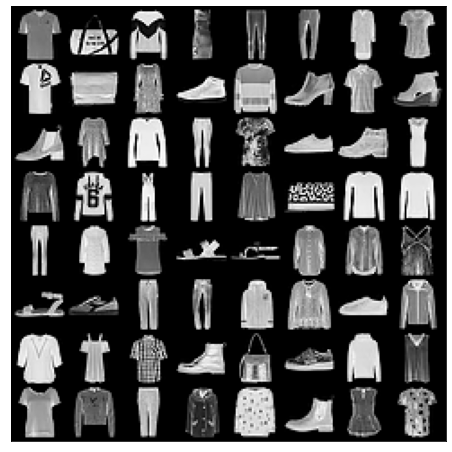

In [ ]:


fmnist_train_iter = iter(fmnist_train_loader)
images, labels = next(fmnist_train_iter)
show_images(torchvision.utils.make_grid(images))

In [ ]:
class_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

np.set_printoptions(linewidth=120)
np.array([class_mapping[labels[j].item()] for j in range(64)]).reshape(8, 8)

array([['T-shirt/Top', 'Bag', 'Pullover', 'Dress', 'Trouser', 'Trouser', 'Shirt', 'T-shirt/Top'],
       ['T-shirt/Top', 'Bag', 'Dress', 'Sneaker', 'Pullover', 'Ankle Boot', 'T-shirt/Top', 'Sandal'],
       ['Ankle Boot', 'Pullover', 'Pullover', 'Trouser', 'T-shirt/Top', 'Sneaker', 'Ankle Boot', 'Dress'],
       ['Pullover', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Bag', 'Pullover', 'Pullover'],
       ['Trouser', 'Coat', 'T-shirt/Top', 'Sandal', 'Sandal', 'Shirt', 'Shirt', 'Shirt'],
       ['Sandal', 'Sneaker', 'Trouser', 'Trouser', 'Coat', 'Shirt', 'Sneaker', 'Coat'],
       ['Shirt', 'Dress', 'Shirt', 'Ankle Boot', 'Bag', 'Sneaker', 'Pullover', 'T-shirt/Top'],
       ['Shirt', 'Pullover', 'Trouser', 'Coat', 'Pullover', 'Ankle Boot', 'Shirt', 'T-shirt/Top']], dtype='<U11')

## A CNN architecture using pytorch-lightning

Since we will use pytorch-lightning, our class needs to inherit from pl.LightningModule

In [ ]:



class FashionCNN(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

**Pro tip.** When coding and debugging your architecture, don't use print statements to check the sizes of input / output tensors for instance. Use pdb (python debbuger) by writing the line
```python
import pdb; pdb.set_trace()
```
at the place where you want to check stuff

In [ ]:
net = FashionCNN()
x = torch.randn(3, 1, 28, 28)
out = net(x)
out.size()

torch.Size([3, 10])

In [ ]:
print(out)

tensor([[-0.0758, -0.0339, -0.0228,  0.2799, -0.0280,  0.1046, -0.0003, -0.0731,
         -0.0134,  0.0201],
        [-0.0427, -0.0769, -0.0502,  0.0830,  0.0132,  0.1128,  0.0283, -0.0321,
          0.0203,  0.0144],
        [ 0.0266, -0.0512,  0.0521,  0.1762,  0.0271,  0.1249,  0.0321,  0.0443,
         -0.1088, -0.0103]], grad_fn=<AddmmBackward>)


In [ ]:
print(net)

FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (accuracy): Accuracy()
)


**Pro tip.** Pytorch lighting proposes many very convenient flags to try and debug before testing. For instance, `fast_dev_run` runs some training and validation steps in order to check that everyting works.

In [ ]:
# Initialize a trainer
trainer = pl.Trainer(gpus=0, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
trainer.fit(net, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

## Train for some epochs


In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer.fit(net, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Check some validation metrics

In [ ]:
# Note: we should increase the batch_size to compute pure forward predictions
predictions = get_predictions(net, fmnist_valid_loader)
scores = F.softmax(predictions, dim=1)

In [ ]:
scores[:3].detach()

In [ ]:

cm = confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1))
cm

In [ ]:
skplt.metrics.plot_confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))

# Your turn ! Here are some things to do

For this homework, do the following:

- Add data augmentation in the transformations used in the DataLoaders (have a look at https://github.com/zalandoresearch/fashion-mnist)
- Look for a better architecture (for instance, change padding and kernel sizes, have a look at https://github.com/zalandoresearch/fashion-mnist), try different solvers / learning rates
- Remove batch normalization, change dropout parameters, try residual connections
- It's possible to reach > 94% accuracy, once again have a look at https://github.com/zalandoresearch/fashion-mnist

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/ --host 0.0.0.0 --port 6006

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## 0) Choice of solver

En premier, nous avons voulu tester différents types de solveur et de learning rate. Nous avons testé trois solveurs :

* Le solveur Adam pour lr = 1e-2e, 1e-3, 1e-4
* Le solveur Adagrade pour lr = 5e-2, 1e-2, 1e-3, 1e-4
* Le solveur SGD pour lr = 5e-2, 1e-2, 1e-3, 1e-4 ( et momentum=0.9, valeur conseillée par proches et internet)

### A. Adagrad

In [ ]:
class FashionCNN_Adagrad(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_Adagrad, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adagrad(self.parameters(), lr=5e-2)

In [ ]:
net_Adagrad= FashionCNN_Adagrad()
trainer_Adagrad = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_Adagrad.fit(net_Adagrad, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

Ce solveur obtient les meilleurs résultats pour un learning rate de 1e-2. Les cas 1e-3 et 5e-2 sont bien moins bons.

### B. SGD

In [ ]:
class FashionCNN_SGD(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_SGD, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=5e-2, momentum=0.9)

In [ ]:
net_SGD= FashionCNN_SGD()
trainer_SGD = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_SGD.fit(net_SGD, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

Ce solveur obtien de bons résulats, lui aussi, pour lr = 1e-2. Pour 5e-2 et 1e-3, les résultats sont là aussi, bien moins bons.

Nous avons observé que pour le réseau proposé initialement, le solveur Adam donne de meilleurs résultats que tous les autres pour lr = 1e-3 et lr= 1e-4. Suivent les solveurs SGD et Adagrad pour lr = 1e-2. 

Nous avons donc décidé de continuer avec le solveur Adam. Nous regarderons légèrement plus en détail le learning rate que nous choisirons dans la prochaine section.


## 1) Change the learning rate

Sachant que ce solveur obtenait de bonnes performances pour 1e-3 et 1e-4, nous avons voulu essayé 5e-4 pour choisir le taux que nous utiliserons dans la suite.

### A. Set at 1e-3

In [ ]:
class FashionCNN_slow(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_slow, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
net_slow = FashionCNN_slow()
trainer_slow = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_slow.fit(net_slow, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


### B. Set at 5e-4

In [ ]:
class FashionCNN_very_slow(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_very_slow, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)

In [ ]:
net_very_slow = FashionCNN_slow()
trainer_very_slow = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_very_slow.fit(net_very_slow, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

### C. Set at 1e-4


In [ ]:
class FashionCNN_very_very_slow(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_very_very_slow, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [ ]:
net_very_very_slow = FashionCNN_slow()
trainer_very_very_slow = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_very_very_slow.fit(net_very_very_slow, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

Après plusieurs essais, il s'est avéré que les trois leraning rate proposés permettaient de bien meilleures performances que celui proposé initialement. La valeuyr 1e-3 s'avérant en moyenne légèrement meilleure, nous l'avons choisie pour la suite.

## 2) Data Augmentation


Dans cette section, nous avons voulu comparer cinq augmentations qui nous paraissaient faire sens dans cette étude. Des inversions de sens de l'image ainsi que des jeux sur le floutage, la distribution des pixels ainsi que des transformations affines.

Nous avons gardé la même configuration du réseau avec le learning rate 1e-3 pour ces essais.

In [ ]:
class FashionCNN_learningrate(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_learningrate, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

### A. Gaussian Augmentation

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_gauss = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.GaussianBlur(3, sigma=(0.1, 1.0))                                
    ])
)

fmnist_valid_gauss = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_gauss = DataLoader(fmnist_train_gauss, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_gauss = DataLoader(fmnist_valid_gauss, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


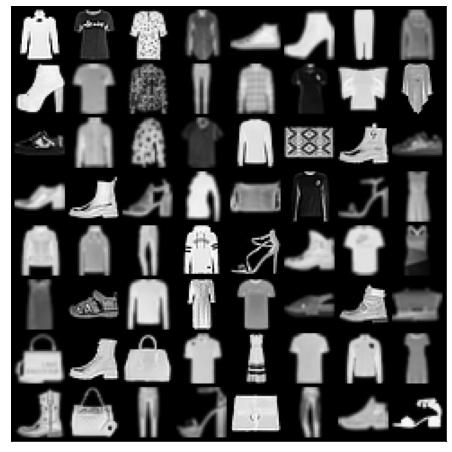

In [ ]:
fmnist_train_iter_gauss = iter(fmnist_train_loader_gauss)
images_gauss, labels_gauss = next(fmnist_train_iter_gauss)
show_images(torchvision.utils.make_grid(images_gauss))

In [ ]:
net_gauss = FashionCNN_learningrate()

In [ ]:
trainer_gauss.fit(net_gauss, train_dataloader=fmnist_train_loader_gauss, val_dataloaders=fmnist_valid_loader_gauss)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


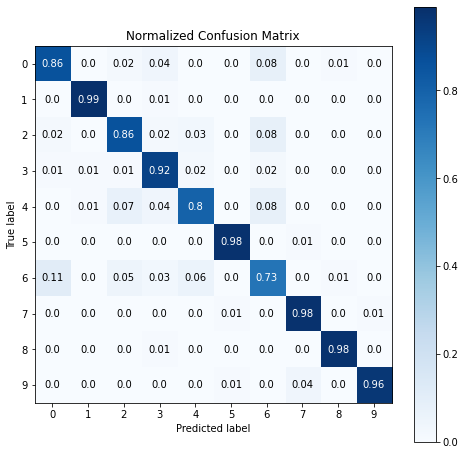

In [ ]:
# Note: we should increase the batch_size to compute pure forward predictions
predictions_gauss = get_predictions(net_gauss, fmnist_valid_loader_gauss)
scores_gauss = F.softmax(predictions_gauss, dim=1)

skplt.metrics.plot_confusion_matrix(fmnist_valid_gauss.targets, scores_gauss.argmax(dim=1), normalize=True, figsize=(8, 8))

### B. Only Random Affine

In [ ]:

# Use standard FashionMNIST dataset
fmnist_train_aff = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomAffine(20)                                
    ])
)

fmnist_valid_aff = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_aff = DataLoader(fmnist_train_aff, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_aff = DataLoader(fmnist_valid_aff, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


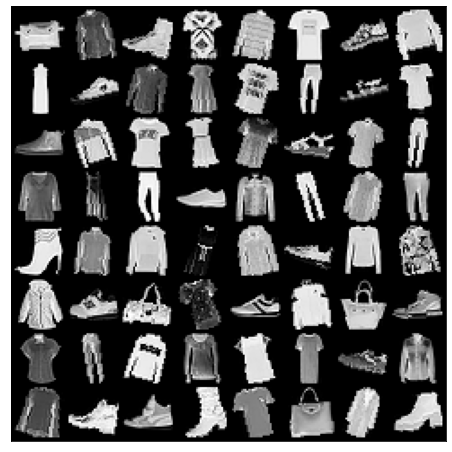

In [ ]:
fmnist_train_iter_aff = iter(fmnist_train_loader_aff)
images_aff, labels_aff = next(fmnist_train_iter_aff)
show_images(torchvision.utils.make_grid(images_aff))

In [ ]:
net_aff = FashionCNN_learningrate()

In [ ]:
trainer_aff = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_aff.fit(net_aff, train_dataloader=fmnist_train_loader_aff, val_dataloaders=fmnist_valid_loader_aff)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1


### C. Only Vertical Flip

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_vert_flip = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomVerticalFlip(p=0.5)                                
    ])
)

fmnist_valid_vert_flip = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_vert_flip = DataLoader(fmnist_train_vert_flip, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_vert_flip = DataLoader(fmnist_valid_vert_flip, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


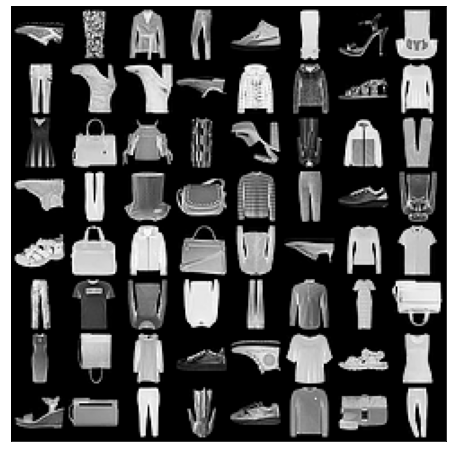

In [ ]:
fmnist_train_iter_vert_flip = iter(fmnist_train_loader_vert_flip)
images_vert_flip, labels_vert_flip = next(fmnist_train_iter_vert_flip)
show_images(torchvision.utils.make_grid(images_vert_flip))

In [ ]:
net_vert_flip = FashionCNN_learningrate()

In [ ]:
trainer_vert_flip = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_vert_flip.fit(net_vert_flip, train_dataloader=fmnist_train_loader_vert_flip, val_dataloaders=fmnist_valid_loader_vert_flip)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

### D. Only Horizontal Flip

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_hori_flip = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5)                                
    ])
)

fmnist_valid_hori_flip = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_hori_flip = DataLoader(fmnist_train_hori_flip, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_hori_flip = DataLoader(fmnist_valid_hori_flip, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


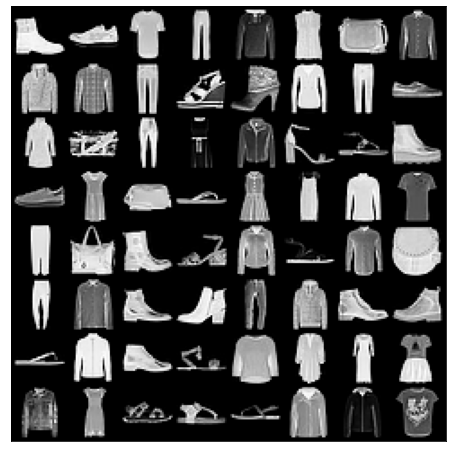

In [ ]:
fmnist_train_iter_hori_flip = iter(fmnist_train_loader_hori_flip)
images_hori_flip, labels_hori_flip = next(fmnist_train_iter_hori_flip)
show_images(torchvision.utils.make_grid(images_hori_flip))

In [ ]:
net_hori_flip = FashionCNN_learningrate()

In [ ]:
trainer_hori_flip = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_hori_flip.fit(net_hori_flip, train_dataloader=fmnist_train_loader_hori_flip, val_dataloaders=fmnist_valid_loader_hori_flip)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

### E. Equalize Augmentation

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_equal = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize(0, 1, inplace=False)                             
    ])
)

fmnist_valid_equal = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_equal = DataLoader(fmnist_train_equal, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_equal = DataLoader(fmnist_valid_equal, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


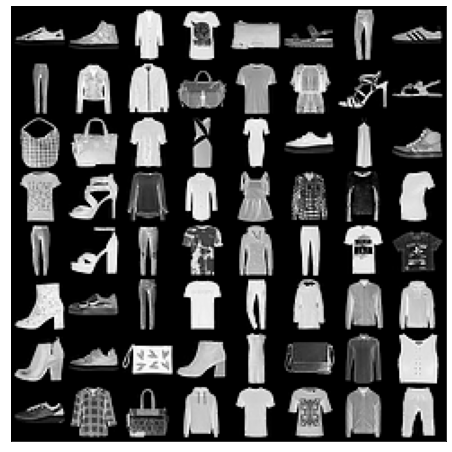

In [ ]:
fmnist_train_iter_equal = iter(fmnist_train_loader_equal)
images_equal, labels_equal = next(fmnist_train_iter_equal)
show_images(torchvision.utils.make_grid(images_equal))

In [ ]:
net_equal = FashionCNN_learningrate()

In [ ]:
trainer_equal = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_equal.fit(net_equal, train_dataloader=fmnist_train_loader_equal, val_dataloaders=fmnist_valid_loader_equal)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

### F. Horizontal Flip and Equalize Augmentations

Après plusieurs essais, seuls la noramalisation des images et les inversions horizontales donnaient de meilleures performances que le réseau initial avec lr = 1e-3. 

Nous émis l'hypothèse que si les différences entre les images augmentées du set de train et les images augmentées du set de validation devenait trop grande, alors le réseau perdait en efficacité. 

Nous avons donc écidé de cumuler les deux transformations qui nous semblaient efficaces. La transformation horizontale qui avait eu un réel apport et la normalisation qui semblait avoir un très léger effet.

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_equal_flips = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.Normalize(0, 1, inplace=False)                             
    ])
)

fmnist_valid_equal_flips = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)

num_workers = 16

fmnist_train_loader_equal_flips = DataLoader(fmnist_train_equal_flips, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_equal_flips = DataLoader(fmnist_valid_equal_flips, batch_size=512, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


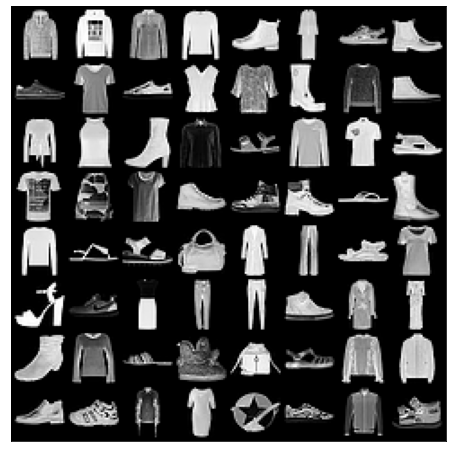

In [ ]:
fmnist_train_iter_equal_flips = iter(fmnist_train_loader_equal_flips)
images_equal_flips, labels_equal_flips = next(fmnist_train_iter_equal_flips)
show_images(torchvision.utils.make_grid(images_equal_flips))

In [ ]:
net_equal_flips = FashionCNN_learningrate()

In [ ]:
trainer_equal_flips = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_equal_flips.fit(net_equal_flips, train_dataloader=fmnist_train_loader_equal_flips, val_dataloaders=fmnist_valid_loader_equal_flips)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

Cette accumulation n'a pas porté ses fruits. C'est pourquoi, nous opterons pour la seule inversion horizontale des images. 

Toutefois, nous nous sommes dit, à posteriori, qu'il était possible que les images aient déjà été normalisées avec moyenne nulle et variance égale à un. Ces deux paramètres étant ceux ayant donné les meilleurs effets, si cette hypothèse s'avérait vraie, cete augmentation ne servirait pas. 

## 3) Improving the network


Pour finir, la partie la plus importante de notre étude était de modifier notre réseau avec de nouvelles features telles que la batch normalization et en modifiant sa structure. 

C'est ce à quoi nous allons nous intéresser maintenant.

In [ ]:
# Use standard FashionMNIST dataset
fmnist_train_final_augm = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5)                                 
    ])
)

fmnist_valid_final_augm = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)


num_workers = 1

fmnist_train_loader_final_augm = DataLoader(fmnist_train_final_augm, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_final_augm = DataLoader(fmnist_valid_final_augm, batch_size=512, num_workers=num_workers)



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### A. Batch Normalization 


Tout d'abord, nous allons comparer la version sans batch normalisation et la version avec de notre réseau. Le learning rate vaut 1e-3 et le solveur est Adam. La data augmentation est seulement composée d'un flip horizontal.
 

In [ ]:
class FashionCNN_batch_norm(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_batch_norm, self).__init__()
        
        # First convolutional block
        # Padding donc aucune reduction taille dans conv, maxpool 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        # Pas de padding donc reduction taille dans conv 14x14 vers 12x12, maxpool 12x12 vers 6x6
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        # 64 elmts de taille 6x6 => vecteur de 2304 elmts
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
net_batch_norm = FashionCNN_batch_norm()

In [ ]:
trainer_batch_norm = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)
trainer_batch_norm.fit(net_batch_norm, train_dataloader=fmnist_train_loader_final_augm, val_dataloaders=fmnist_valid_loader_final_augm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 384   
1 | conv_block2 | Sequential | 18.6 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

In [ ]:
# Note: we should increase the batch_size to compute pure forward predictions
predictions_batch_norm = get_predictions(net_batch_norm, fmnist_valid_loader_final_augm)
scores_batch_norm = F.softmax(predictions_batch_norm, dim=1)

Le gain est faible mais il existe; nous garderons cette feature dans la suite.

### B. New convs 


Pour la modification de la structure, nous avons d'abord essayé de rajouter une voire deux convolutions. Nous avons modifié les paddings ainsi que le stride. L'amélioration était très légère, c'est pourquoi nous nous sommes inspiré de ce que nous avions fait pour le premier dm sous keras. La structure du réseau fonctionnait bien.

Nous avons rajouté deux convolutions. Le nombre de kernel est multiplié par deux entre chaque convolution en partant d'une valeur de 128.

De plus,  nous avons gardé un seul layer après le dernier dropout.

In [ ]:
class FashionCNN_new_convs(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_new_convs, self).__init__()
        
        # First convolutional block
        # 28x28 vers 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )
        
        # Second convolutional block
        # 14x14 vers 14x14 vers 7x7
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 7x7 vers 6x6 vers 3x3 
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 3x3 vers 1x1
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1028, kernel_size=3),
            nn.BatchNorm2d(1028),
            nn.ReLU()
        )
        
        # Fully connected layers
        # 256 elmts de taille 1x1 => vecteur de 256 elmts
        self.fc1 = nn.Linear(in_features=1028, out_features=100)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # pourquoi deux transfo lineaires sans activation ?
        self.fc2 = nn.Linear(in_features=100, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
net_new_convs = FashionCNN_new_convs()

In [ ]:
trainer_new_convs = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20)
trainer_new_convs.fit(net_new_convs, train_dataloader=fmnist_train_loader_final_augm, val_dataloaders=fmnist_valid_loader_final_augm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 1.5 K 
1 | conv_block2 | Sequential | 295 K 
2 | conv_block3 | Sequential | 525 K 
3 | conv_block4 | Sequential | 4.7 M 
4 | fc1         | Linear     | 102 K 
5 | drop        | Dropout2d  | 0     
6 | fc2         | Linear     | 1.0 K 
7 | accuracy    | Accuracy   | 0     
-------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.668    Total estimated model params size (MB)


1

L'accuracy augmente de quelques pourcents pour atteindre plus de 93% lors d'un entrainement sur 30 epoques.

Nous garderons ce réseau dans la suite.

### C. Adding Residual Connections

Nous avons décidé de tester trois structures différentes avec connections résiduelles. 

Tout d'abord nous testons l'ajout des informations de départ x0 dans la première couche dense du réseau. 

Ensuite nous essayons de rajouter l'output de la premère convolution. Le vecteur est alors beaucoup plus grand : 128 images 14x14.

Por terminer, nous avons essayer de garder le réseau avec l'output de première convolution et d'y rajouter les informations de l'image de départ dans la dernière couche dense.

In [ ]:
class FashionCNN_res_conv(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_res_conv, self).__init__()
        
        # First convolutional block
        # 28x28 vers 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )
        
        # Second convolutional block
        # 14x14 vers 14x14 vers 7x7
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 7x7 vers 6x6 vers 3x3 
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 3x3 vers 1x1
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1028, kernel_size=3),
            nn.BatchNorm2d(1028),
            nn.ReLU()
        )
        
        # Fully connected layers
        # 1028 elmts de taille 1x1 + 14x14x128=25088 => vecteur de 26116 elmts
        self.fc1 = nn.Linear(in_features=26116, out_features=100)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.conv_block3(x2)
        x4 = self.conv_block4(x3)
        return torch.cat((x4.view(x4.size(0),-1),x1.view(x1.size(0),-1)),1)
        
    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
net_res_conv = FashionCNN_res_conv()
trainer_res_conv = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20)
trainer_res_conv.fit(net_res_conv, train_dataloader=fmnist_train_loader_final_augm, val_dataloaders=fmnist_valid_loader_final_augm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 1.5 K 
1 | conv_block2 | Sequential | 295 K 
2 | conv_block3 | Sequential | 525 K 
3 | conv_block4 | Sequential | 4.7 M 
4 | fc1         | Linear     | 2.6 M 
5 | drop        | Dropout2d  | 0     
6 | fc2         | Linear     | 1.0 K 
7 | accuracy    | Accuracy   | 0     
-------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.703    Total estimated model params size (MB)


1

L'ajout des informations de l'image de départ et de l'output de la première convolution n'a pas apporté grand chose. Nous allons essayé de coder deux connections résiduelles.

In [ ]:
class FashionCNN_res_conv(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_res_conv, self).__init__()
        
        # First convolutional block
        # 28x28 vers 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )
        
        # Second convolutional block
        # 14x14 vers 14x14 vers 7x7
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 7x7 vers 6x6 vers 3x3 
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 3x3 vers 1x1
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1028, kernel_size=3),
            nn.BatchNorm2d(1028),
            nn.ReLU()
        )
        
        # Fully connected layers
        # 1028 elmts de taille 1x1 + 14x14x128=25088 => vecteur de 26116 elmts
        self.fc1 = nn.Linear(in_features=26116, out_features=100)
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        # 100 elmts + 28x28=784 => vecteur de 884 elmts
        self.fc2 = nn.Linear(in_features=884, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.conv_block3(x2)
        x4 = self.conv_block4(x3)
        return torch.cat((x4.view(x4.size(0),-1),x1.view(x1.size(0),-1)),1)
        
    def classifier(self, x,x0):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out=torch.cat((out,x0),1)
        out = self.fc2(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features,x.view(x.size(0),-1))
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
net_res_conv = FashionCNN_res_conv()
trainer_res_conv = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20)
trainer_res_conv.fit(net_res_conv, train_dataloader=fmnist_train_loader_final_augm, val_dataloaders=fmnist_valid_loader_final_augm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 1.5 K 
1 | conv_block2 | Sequential | 295 K 
2 | conv_block3 | Sequential | 525 K 
3 | conv_block4 | Sequential | 4.7 M 
4 | fc1         | Linear     | 2.6 M 
5 | drop        | Dropout2d  | 0     
6 | fc2         | Linear     | 8.8 K 
7 | accuracy    | Accuracy   | 0     
-------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.735    Total estimated model params size (MB)


1

Encore une fois, l'ajout de connections résiduelles n'a pas apporté grand chose. Nous garderons notre réseau sans ce type de feature pour la suite.

## 4) Conclusion

Voici donc notre réseau final :

* Data Agmentation : Flip horizontaux avec proba 0.5
* Solveur : Adam
* Learning Rate : 1e-3
* Batch Normalization dans chaque layer
* Quatre convolutions 
* Pas de residual connections




In [5]:
# Use standard FashionMNIST dataset
fmnist_train_final = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5)                                 
    ])
)

fmnist_valid_final = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                
    ])
)


num_workers = 1

fmnist_train_loader_final = DataLoader(fmnist_train_final, batch_size=64, num_workers=num_workers, shuffle=True)
fmnist_valid_loader_final = DataLoader(fmnist_valid_final, batch_size=512, num_workers=num_workers)


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


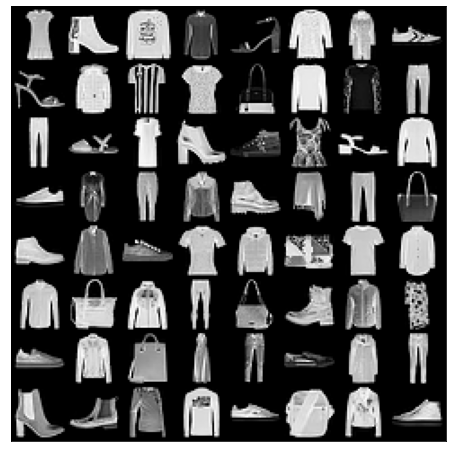

In [6]:
fmnist_train_iter_final = iter(fmnist_train_loader_final)
images_final, labels_final = next(fmnist_train_iter_final)
show_images(torchvision.utils.make_grid(images_final))

In [7]:
class FashionCNN_final(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN_final, self).__init__()
        
        # First convolutional block
        # 28x28 vers 28x28 vers 14x14
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )
        
        # Second convolutional block
        # 14x14 vers 14x14 vers 7x7
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 7x7 vers 6x6 vers 3x3 
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.25, inplace=False)
        )

        # 3x3 vers 1x1
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1028, kernel_size=3),
            nn.BatchNorm2d(1028),
            nn.ReLU()
        )
        
        # Fully connected layers
        # 256 elmts de taille 1x1 => vecteur de 256 elmts
        self.fc1 = nn.Linear(in_features=1028, out_features=100)
        self.act= nn.ReLU()
        # devrait etre dropout simple car 1d
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out=self.act(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [8]:
net_final = FashionCNN_final()
trainer_final = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20)
trainer_final.fit(net_final, train_dataloader=fmnist_train_loader_final, val_dataloaders=fmnist_valid_loader_final)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 1.5 K 
1 | conv_block2 | Sequential | 295 K 
2 | conv_block3 | Sequential | 525 K 
3 | conv_block4 | Sequential | 4.7 M 
4 | fc1         | Linear     | 102 K 
5 | act         | ReLU       | 0     
6 | drop        | Dropout2d  | 0     
7 | fc2         | Linear     | 1.0 K 
8 | accuracy    | Accuracy   | 0     
-------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.668    Total estimated model params size (MB)


1

Nous obtenons une accuracy proche des 93%.